In [1]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

pb.ion()

file_base = "modularized_v5_backup/"

X = np.load("hc_baby.npy", allow_pickle=True)
Y = np.log(np.load("samples_baby.npy", allow_pickle=True))

In [2]:
X_raw = np.load(file_base + "hc_backup_i599_massless_predictor.npy", allow_pickle=True)
Y_raw = np.load(file_base + "samples_backup_i599_massless_predictor.npy", allow_pickle=True)
X_raw = X_raw[:600]
Y_raw = Y_raw[:600]

In [3]:
scale_factor = np.load("standard_k.npy", allow_pickle=True)

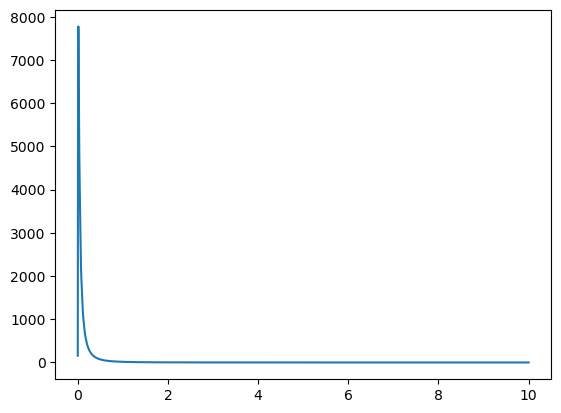

In [4]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.plot(scale_factor, Y_raw[0])

In [5]:
''' To get a sense of how much we're deleting.
for i in range(len(Y_truncated)):
    pspec = Y_truncated[i]
    if float('-inf') in pspec:
        print("-inf")
    if float('inf') in pspec:
        print("inf")
    if None in pspec:
        print("None")
    if True in np.isnan(pspec):
        print("NaN in row", i)
        print(X_truncated[i])
    if 0 in pspec:
        print("zero")
'''

' To get a sense of how much we\'re deleting.\nfor i in range(len(Y_truncated)):\n    pspec = Y_truncated[i]\n    if float(\'-inf\') in pspec:\n        print("-inf")\n    if float(\'inf\') in pspec:\n        print("inf")\n    if None in pspec:\n        print("None")\n    if True in np.isnan(pspec):\n        print("NaN in row", i)\n        print(X_truncated[i])\n    if 0 in pspec:\n        print("zero")\n'

In [6]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [7]:
# Now the goal is to compute summary statistics on Y for each value k
Ylog = np.log(Y)
mu = np.mean(Ylog, axis=0)
mu.shape
stdev = np.std(Ylog, axis=0)
stdev.shape

(300,)

In [8]:
# now normalize the data with these summary statistics
Y_normalized = cp.deepcopy(Ylog)

for i in range(len(Y)):
    Y_normalized[i] -= mu
    Y_normalized[i] /= stdev

In [9]:
def inverse_transform(raw_prediction):
    return np.exp(raw_prediction * stdev + mu)

In [10]:
print(X.shape, Y_normalized.shape)

(600, 4) (600, 300)


In [12]:
kernel = GPy.kern.RBF(input_dim=4, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y_normalized,kernel)

In [13]:
m.constrain_positive('') # '' is a regex matching all parameter names
m.optimize()

 /home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


In [14]:
import pickle
m.mu = mu
m.stdev = stdev
pickle.dump(m, open("analyses/massless_emulator.nucomet", "wb"), protocol=5) 

In [15]:
# Remember that the structure of an hc entry is DIFFERENT NOW
# omb, omc, ns, s12, As, omnu
x = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 2.12723788013000E-09
])])
x

array([[2.24450000e-02, 1.20567000e-01, 9.60000000e-01, 8.24667740e-01,
        2.12723788e-09]])

In [16]:
guess, uncertainties = m.predict(x)

Text(0.5, 0, 'scale factor k')

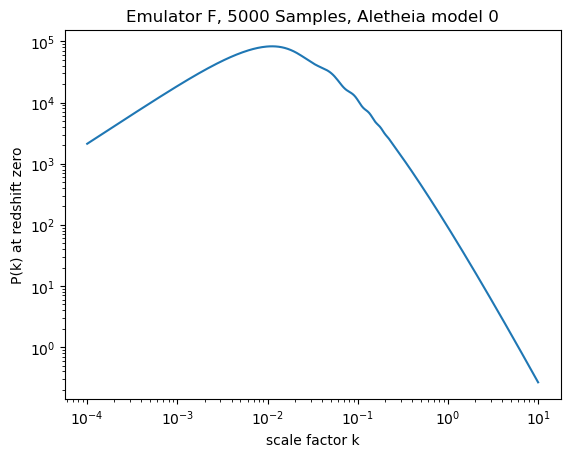

In [17]:
#import matplotlib.pyplot as plt
pb.loglog(scale_factor, inverse_transform(guess[0]))
pb.title("Emulator F, 5000 Samples, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale factor k')

In [18]:
# Now let's check our work with battery
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

# Compare like to like
massless_cosmology = spectra.specify_neutrino_mass(spectra.cosm.iloc[0], 0, 0)
k_m0truth, z_m0truth, p_m0truth, s_m0truth = \
    spectra.kzps(massless_cosmology, zs=[0], k_points=300)
print(s_m0truth)

[0.82466774]


Text(0.5, 0, 'scale factor k')

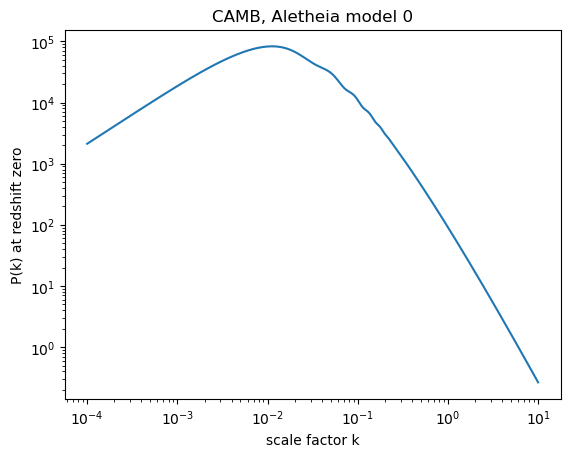

In [19]:
#import matplotlib.pyplot as plt
pb.loglog(k_m0truth, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale factor k')

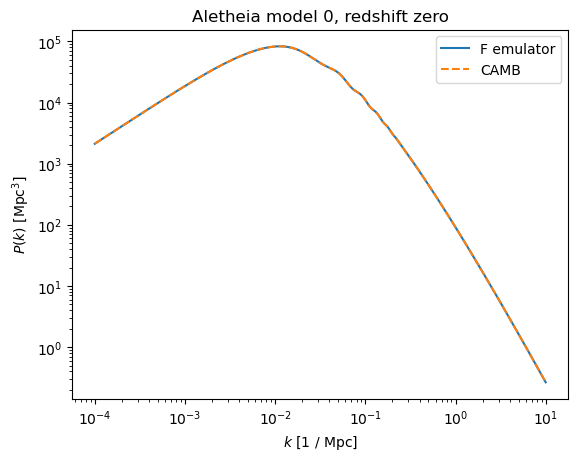

In [31]:
pb.plot(scale_factor, inverse_transform(guess[0]),
    label="F emulator")
pb.loglog(k_m0truth, p_m0truth, label="CAMB", linestyle="dashed")
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('$k$ [1 / Mpc]')
pb.legend()

Text(0.5, 0, '$k$ [1 / Mpc]')

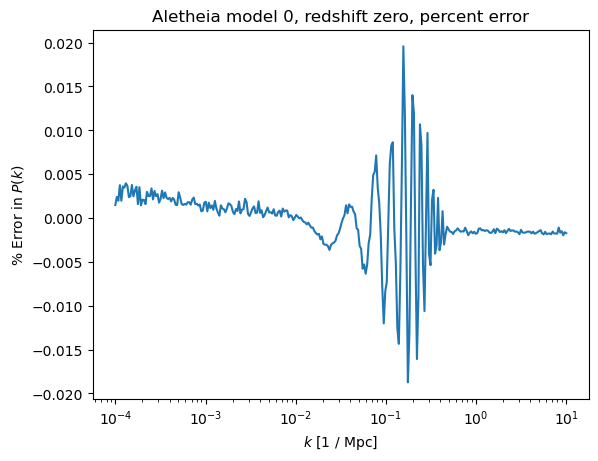

In [21]:
pb.plot(scale_factor,
    (inverse_transform(guess[0]) - p_m0truth) / p_m0truth * 100)
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$')
pb.xlabel('$k$ [1 / Mpc]')

Pretty encouraging for such an early iteration.

In [22]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.01, 0.82466774, 0, 2.12723788013000E-09
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.92, 0.82466774, 0, 2.12723788013000E-09
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(x_lo_ns)


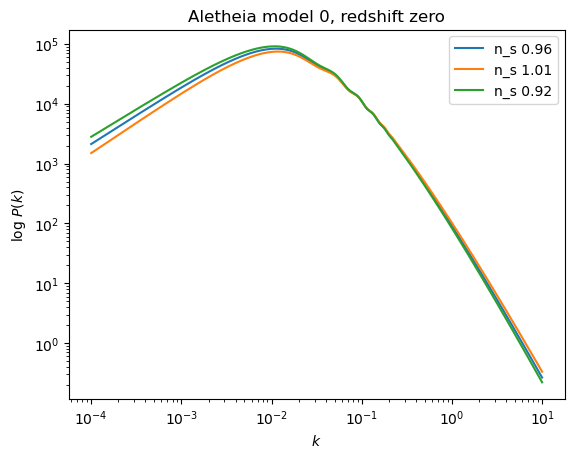

In [23]:
pb.loglog(scale_factor, inverse_transform(guess[0]), label="n_s 0.96")
pb.loglog(scale_factor, inverse_transform(guess_hi_ns[0]), label="n_s 1.01")
pb.loglog(scale_factor, inverse_transform(guess_lo_ns[0]), label="n_s 0.92")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [24]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omb = np.array([np.array([
    0.02415, 0.120567, 0.96, 0.82466774, 0,\
    2.12723788013000E-09
])])
guess_hi_omb, uncertainties_hi_omb = m.predict(x_hi_omb)

x_lo_omb = np.array([np.array([
    0.0205, 0.120567, 0.96, 0.82466774, 0, \
    2.12723788013000E-09
])])
guess_lo_omb, uncertainties_lo_omb = m.predict(x_lo_omb)


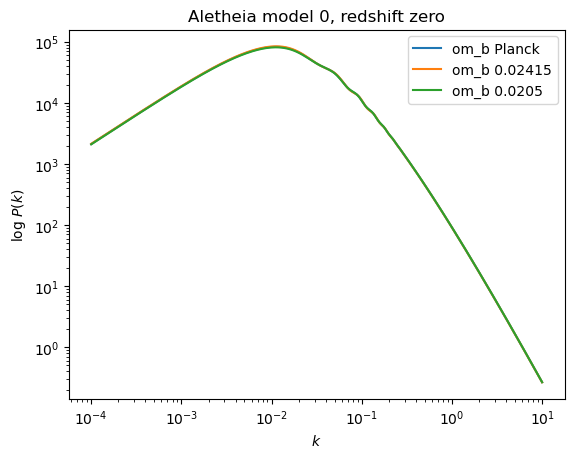

In [25]:
pb.loglog(scale_factor, inverse_transform(guess[0]),
        label="om_b Planck")
pb.loglog(scale_factor, inverse_transform(guess_hi_omb[0]),
        label="om_b 0.02415")
pb.loglog(scale_factor, inverse_transform(guess_lo_omb[0]),
        label="om_b 0.0205")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [26]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omc = np.array([np.array([
    0.022445, 0.155, 0.96, 0.82466774, 0,\
    2.12723788013000E-09
])])
guess_hi_omc, uncertainties_hi_omc = m.predict(x_hi_omc)

x_lo_omc = np.array([np.array([
    0.022445, 0.085, 0.96, 0.82466774, 0, \
    2.12723788013000E-09
])])
guess_lo_omc, uncertainties_lo_omc = m.predict(x_lo_omc)


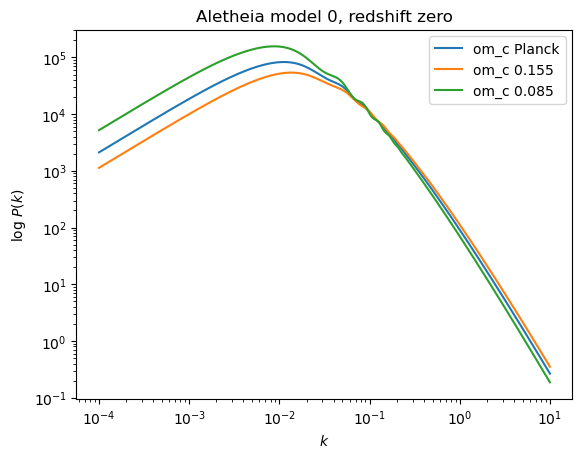

In [27]:
pb.loglog(scale_factor, inverse_transform(guess[0]),
        label="om_c Planck")
pb.loglog(scale_factor, inverse_transform(guess_hi_omc[0]),
        label="om_c 0.155")
pb.loglog(scale_factor, inverse_transform(guess_lo_omc[0]),
        label="om_c 0.085")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

In [28]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(3.91) / 10 ** 10
])])
guess_hi_As, uncertainties_hi_As = m.predict(x_hi_As)
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774, 0, np.exp(2.35) / 10 ** 10 
])])
guess_lo_As, uncertainties_lo_As = m.predict(x_lo_As)

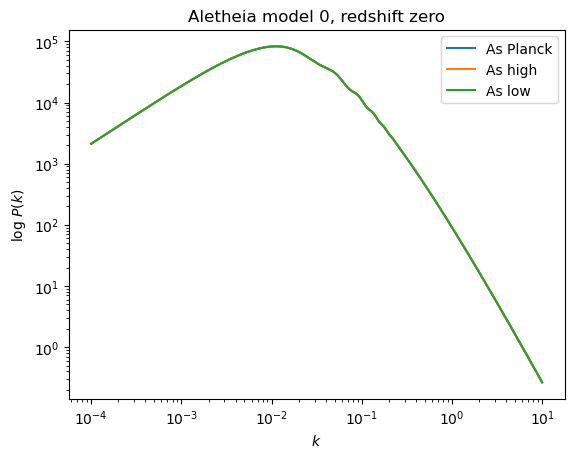

In [29]:
pb.loglog(scale_factor, inverse_transform(guess[0]), label="As Planck")
pb.loglog(scale_factor, inverse_transform(guess_hi_As[0]), label="As high")
pb.loglog(scale_factor, inverse_transform(guess_lo_As[0]), label="As low")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('$k$')
pb.legend()

I guess this shows that sigma12 countermands As, huh?